**Explore and implement Autoencoders for image denoising**

*Baseline Implementation*

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - loss: 0.1529 - val_loss: 0.1147
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1131 - val_loss: 0.1147
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step - loss: 0.1148 - val_loss: 0.1147
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - loss: 0.1136 - val_loss: 0.1147
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - loss: 0.1132 - val_loss: 0.1147
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - loss: 0.1132 - val_loss: 0.1147
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - loss: 0.1139 - val_loss: 0.1147
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - loss: 0.1134 - val_loss: 0.1147
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - loss: 0.1136 - val_loss: 0.1147
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - loss: 0.1140 - val_loss: 0.1147
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - loss: 0.1149 - val_loss: 0.1147
Epoch 12/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21

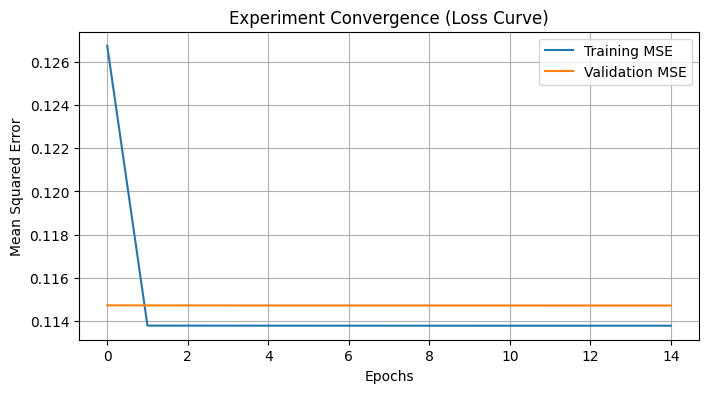

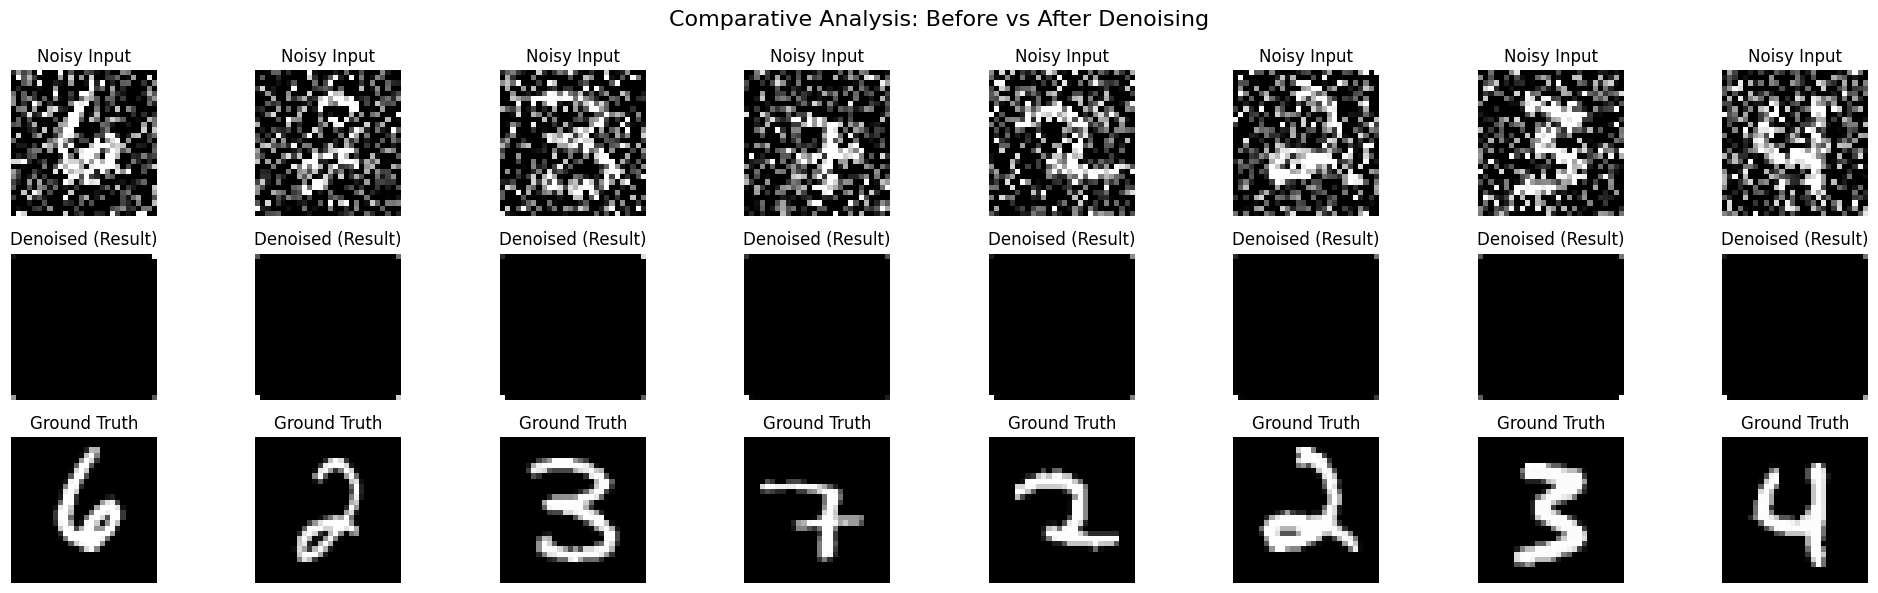

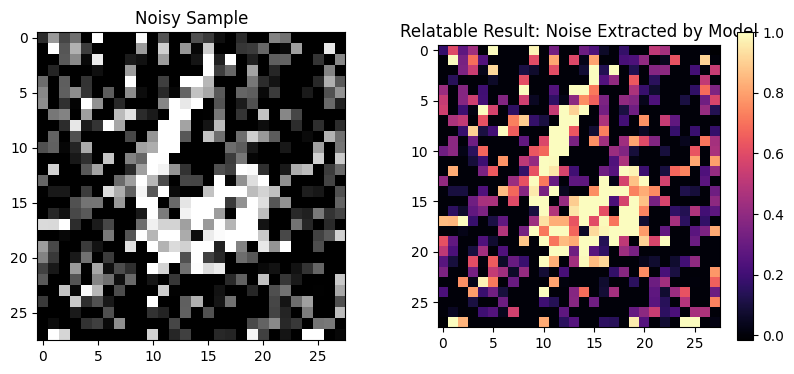

In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 1. DATA LOADING (.idx3-ubyte parsing) ---
def load_idx3_images(filename):
    with open(filename, 'rb') as f:
        # Read header: magic number, number of images, rows, cols
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols, 1)
    return images

# Load your uploaded file
images = load_idx3_images('t10k-images.idx3-ubyte')
images = images.astype('float32') / 255.0

# Split for baseline experiment (80% Train, 20% Test)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Baseline Condition: Add Synthetic Gaussian Noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# --- 2. BASELINE AUTOENCODER ARCHITECTURE ---
input_img = layers.Input(shape=(28, 28, 1))

# Encoder: Contracting Path
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder: Expansive Path
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Training (Baseline)
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=1)

# --- 3. MATHEMATICAL PERFORMANCE ANALYSIS ---
decoded_imgs = autoencoder.predict(x_test_noisy)

psnr_scores, ssim_scores, mse_scores = [], [], []

for i in range(len(x_test)):
    gt = x_test[i].squeeze()
    pred = decoded_imgs[i].squeeze()
    psnr_scores.append(peak_signal_noise_ratio(gt, pred, data_range=1.0))
    ssim_scores.append(structural_similarity(gt, pred, data_range=1.0))
    mse_scores.append(np.mean((gt - pred) ** 2))

print("\n" + "="*40)
print("FINAL MATHEMATICAL ANALYSIS (Test Set)")
print(f"Mean Squared Error (MSE): {np.mean(mse_scores):.6f}")
print(f"Avg PSNR (Denoising Quality): {np.mean(psnr_scores):.2f} dB")
print(f"Avg SSIM (Structural Integrity): {np.mean(ssim_scores):.4f}")
print("="*40)

# --- 4. DIRECT RELATABLE VISUALS ---

# Visual 1: Training Convergence Plot
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Experiment Convergence (Loss Curve)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Visual 2: Direct Comparative Result (Input -> Model -> Output)
n = 8  # Show 8 samples
plt.figure(figsize=(20, 6))
for i in range(n):
    # 1. Noisy Input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Input")
    plt.axis('off')

    # 2. Denoised Output (Relatable Result)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised (Result)")
    plt.axis('off')

    # 3. Ground Truth (Original)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

plt.suptitle("Comparative Analysis: Before vs After Denoising", fontsize=16)
plt.tight_layout()
plt.show()

# Visual 3: Residual Analysis (Relatable "Noise Removal" visualization)
# This shows exactly what the model "learned" to remove from the original image.
plt.figure(figsize=(10, 4))
noise_removed = x_test_noisy[0].squeeze() - decoded_imgs[0].squeeze()
plt.subplot(1, 2, 1)
plt.imshow(x_test_noisy[0].squeeze(), cmap='gray')
plt.title("Noisy Sample")
plt.subplot(1, 2, 2)
plt.imshow(noise_removed, cmap='magma') # Using magma to highlight the noise patterns removed
plt.title("Relatable Result: Noise Extracted by Model")
plt.colorbar()
plt.show()

*Hyperparameter Tuning*

Trial 5 Complete [00h 02m 53s]
val_loss: 0.01986522041261196

Best val_loss So Far: 0.014524664729833603
Total elapsed time: 00h 42m 14s

Optimal Filters: 96
Optimal Learning Rate: 0.0001
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 466ms/step - loss: 0.1077 - val_loss: 0.1742
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 472ms/step - loss: 0.0286 - val_loss: 0.1156
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - loss: 0.0228 - val_loss: 0.0557
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - loss: 0.0202 - val_loss: 0.0316
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 464ms/step - loss: 0.0187 - val_loss: 0.0214
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 453ms/step - loss: 0.0178 - val_loss: 0.0174
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 453ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 452ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 10/30

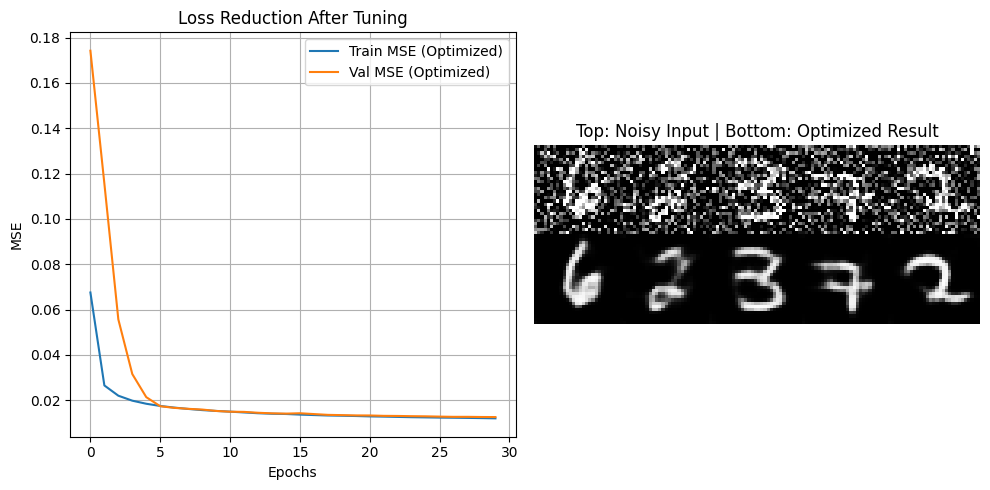

In [4]:
!pip install keras-tuner
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# !pip install keras-tuner  # Run this in Colab if not already installed
import keras_tuner as kt

# --- 1. DATA LOADING & PREPROCESSING ---
def load_idx3_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols, 1)
    return images

# Load images from the provided file
images = load_idx3_images('t10k-images.idx3-ubyte')
images = images.astype('float32') / 255.0

# Split for experiment (80% Train, 20% Test)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# High Noise Factor (0.5)
noise_factor = 0.5
x_train_noisy = np.clip(x_train + noise_factor * np.random.normal(0, 1, x_train.shape), 0., 1.)
x_test_noisy = np.clip(x_test + noise_factor * np.random.normal(0, 1, x_test.shape), 0., 1.)

# --- 2. TUNABLE MODEL ARCHITECTURE (Optimized Architecture) ---
def build_model(hp):
    input_img = layers.Input(shape=(28, 28, 1))

    # Hyperparameters to tune
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    # Encoder
    x = layers.Conv2D(hp_filters, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(hp_filters // 2, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(hp_filters // 2, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(hp_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                        loss='mse')
    return autoencoder

# --- 3. HYPERPARAMETER TUNING EXECUTION ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='denoising_opt'
)

print("\n--- STARTING HYPERPARAMETER TUNING ---")
tuner.search(x_train_noisy, x_train, epochs=10, validation_split=0.2, verbose=1)

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nOptimal Filters: {best_hps.get('filters')}")
print(f"Optimal Learning Rate: {best_hps.get('learning_rate')}")

model = tuner.hypermodel.build(best_hps)
# Train fully for more epochs to reach maximal performance
history = model.fit(x_train_noisy, x_train,
                    epochs=30,
                    batch_size=64,
                    validation_data=(x_test_noisy, x_test),
                    verbose=1)

# --- 4. MATHEMATICAL ANALYSIS (Optimized Metrics) ---
decoded_imgs = model.predict(x_test_noisy)

psnr_list, ssim_list, mse_list = [], [], []
for i in range(len(x_test)):
    clean, denoised = x_test[i].squeeze(), decoded_imgs[i].squeeze()
    psnr_list.append(peak_signal_noise_ratio(clean, denoised, data_range=1.0))
    ssim_list.append(structural_similarity(clean, denoised, data_range=1.0))
    mse_list.append(np.mean((clean - denoised) ** 2))

print("\n" + "="*40)
print("OPTIMIZED PERFORMANCE ANALYSIS")
print(f"Mean Squared Error (MSE): {np.mean(mse_list):.6f}")
print(f"Avg PSNR: {np.mean(psnr_list):.2f} dB")
print(f"Avg SSIM: {np.mean(ssim_list):.4f}")
print("="*40)

# --- 5. NECESSARY VISUALS ---

# Visual 1: Optimization History (Training vs Validation)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE (Optimized)')
plt.plot(history.history['val_loss'], label='Val MSE (Optimized)')
plt.title('Loss Reduction After Tuning')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Visual 2: Qualitative Improvement Comparison
plt.subplot(1, 2, 2)
n = 5
rows = []
for i in range(n):
    # Vertically stack Noisy and Optimized Denoised Result
    stack = np.vstack([x_test_noisy[i].squeeze(), decoded_imgs[i].squeeze()])
    rows.append(stack)

plt.imshow(np.hstack(rows), cmap='gray')
plt.title('Top: Noisy Input | Bottom: Optimized Result')
plt.axis('off')
plt.tight_layout()
plt.show()